In [230]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

import sigkernel as ksig_pde
import sigkernel_ as ksig_disc
import utils.data
from generators.synthetic_generators import *
from generators.ESN import ESNGenerator
from sigkernel_.loss import compute_mmd_loss
from sigkernel_.kernels import gram
from utils.kernel_helpers import median_heuristic_sigma, tune_tau_coef_for_cv

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generator and ESN

In [231]:
# Generator and ESN details ----------------------
T = 200 # length of time series
N = 20  # number of samples
d = 1   # dimension of time series
p = 2   # AR order
q = 0   # MA order
phi = [0.7, -0.2] # AR coefficients
theta = None # MA coefficients

h, m, d = 500, 20, 1 # ESN hyperparameters: reservoir size, input dimension (\xi : randomness), output dimension
A = 0.9 * torch.randn(h, h) / (h ** 0.5) # ESN reservoir weight matrix
C = torch.randn(h, m) / (m ** 0.5) # ESN input weight matrix
activation = "tanh"

# Define data generator and esn
target_generator = ARMA(T=T, p=p, q=q, phi=phi, theta=theta)
esn = ESNGenerator(A, C, out_dim=d, xi_scale=1.0, eta_scale=0.05, activation=activation)

# Generate examples

In [232]:
with torch.no_grad():
    X = target_generator.generate(N=N, noise=Noise("normal")).to(device=device, dtype=dtype)
    Z = esn(T=T, N=N).to(device=device, dtype=dtype)
print(f"Generated data shapes: X: {X.shape}, Z: {Z.shape}")

Generated data shapes: X: torch.Size([20, 200, 1]), Z: torch.Size([20, 200, 1])


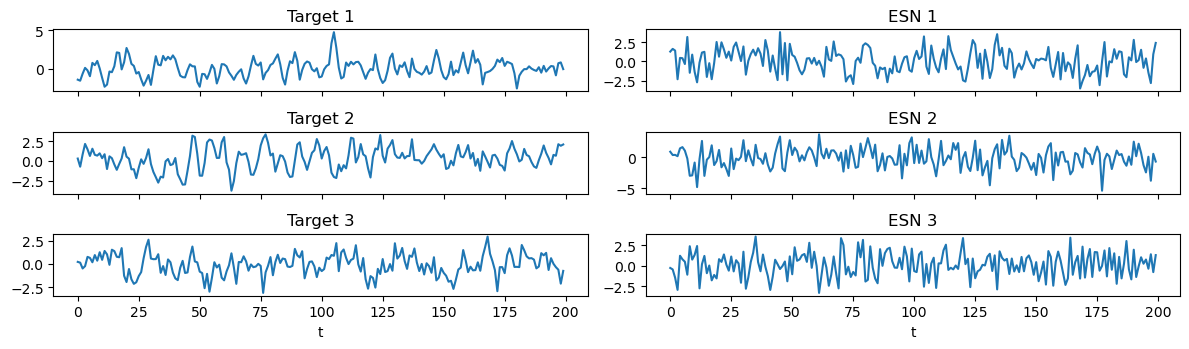

In [233]:
# visualize the current generators
n_examples = 3
fig, axes = plt.subplots(nrows=n_examples, ncols=2, figsize=(12, 1.2 * n_examples), sharex=True)
if n_examples == 1:
    axes = axes.reshape(1, 2)

for i in range(n_examples):
    axes[i, 0].plot(X[i, :, 0].numpy())
    axes[i, 0].set_title(f"Target {i+1}")
    axes[i, 1].plot(Z[i, :, 0].numpy())
    axes[i, 1].set_title(f"ESN {i+1}")
for ax in axes[-1, :]:
    ax.set_xlabel("t")
plt.tight_layout()
plt.show()

# Kernels

Given two sets of points $\{x_i\}_{i=1}^n$ and $\{y_j\}_{j=1}^m$, we compute the pairwise squared Euclidean distances
$$
d_{ij} = \lVert x_i - y_j \rVert^2, \qquad i = 1,\dots,n,\; j = 1,\dots,m.
$$

The median heuristic sets the kernel bandwidth according to
$$
\sigma^2 = \operatorname{median}\{ d_{ij} : 1 \le i \le n,\; 1 \le j \le m \},
$$
or, equivalently,
$$
\sigma = \sqrt{\operatorname{median}(d_{ij})}.
$$


In [234]:
median_heuristic_sigma_val = median_heuristic_sigma(X, Z)
print(f"Median heuristic sigma: {median_heuristic_sigma_val:.4f}")

# Define the discretized signature kernel (note that the median heuristic sigma doesn't work for rq)
static_kernel_type_disc    = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels              = 10 # number of levels in the truncated signature kernel
disc_sig_kernel_sigma = median_heuristic_sigma_val # bandwidth parameter for the static kernel

kwargs_disc_sig = {
    'static_kernel_type': static_kernel_type_disc,
    'n_levels': n_levels,
    'kernel_sigma': disc_sig_kernel_sigma,
}

sig_disc_kernel = ksig_disc.kernels.get_discretized_signature_kernel(**kwargs_disc_sig)

#---------------------------------
# Define the pde signature kernel
pde_sig_sigma = median_heuristic_sigma_val # bandwidth parameter for the static kernel
static_kernel_pde = ksig_pde.RBFKernel(sigma=pde_sig_sigma) # define static kernel

# Initialize the corresponding signature kernel
sig_pde_kernel = ksig_pde.SigKernel(static_kernel_pde, dyadic_order=0)

#---------------------------------
# Define static kernel
static_sigma = median_heuristic_sigma_val
rbf_kernel = ksig_disc.kernels.RBFKernel(sigma=static_sigma)

#---------------------------------
# Volterra kernel
ld_coef = 0.7
tau_best, cv_best, spec_best = tune_tau_coef_for_cv(X, ld_coef=ld_coef)
tau_coef = tau_best
volterra_kernel = ksig_disc.kernels.VolterraKernel(ld_coef=ld_coef, tau_coef=tau_coef)
volterra_kernel.fit(X) # fitting is needed to compute lambda, tau and the normalization constant
print(f"Best tau: {tau_best}, CV: {cv_best}")

Median heuristic sigma: 28.4591
Best tau: 0.7525, CV: 0.010800071815096622


# RBF

In [235]:
rbf_gram = gram(rbf_kernel, X.reshape(X.shape[0], -1), Z.reshape(Z.shape[0], -1))
print("RBF Gram matrix stats:")
print(f"Shape: {rbf_gram.shape}")
print(f"Min: {rbf_gram.min().item():.4f}")
print(f"Max: {rbf_gram.max().item():.4f}")
print(f"Mean: {rbf_gram.mean().item():.4f}")
print(f"Std: {rbf_gram.std().item():.4f}")

print("First 3 rows and columns of RBF Gram matrix:")
print(rbf_gram[:3, :3])

RBF Gram matrix stats:
Shape: torch.Size([20, 20])
Min: 0.2580
Max: 0.4764
Mean: 0.3666
Std: 0.0405
First 3 rows and columns of RBF Gram matrix:
tensor([[0.3944, 0.3443, 0.4196],
        [0.3639, 0.2928, 0.3828],
        [0.4126, 0.3704, 0.4154]], dtype=torch.float64)


In [236]:
mmd_rbf = compute_mmd_loss(rbf_kernel, X.reshape(X.shape[0], -1), Z.reshape(Z.shape[0], -1))
print(f"MMD (RBF kernel): {mmd_rbf.item():.6f}")

MMD (RBF kernel): 0.025289


# SIG-PDE

In [237]:
sig_pde_gram = gram(sig_pde_kernel, X, Z)
print("sig_pde Gram matrix stats:")
print(f"Shape: {sig_pde_gram.shape}")
print(f"Min: {sig_pde_gram.min().item():.4f}")
print(f"Max: {sig_pde_gram.max().item():.4f}")
print(f"Mean: {sig_pde_gram.mean().item():.4f}")
print(f"Std: {sig_pde_gram.std().item():.4f}")

print("First 3 rows and columns of sig_pde Gram matrix:")
print(sig_pde_gram[:3, :3])

sig_pde Gram matrix stats:
Shape: torch.Size([20, 20])
Min: 0.1827
Max: 2.4404
Mean: 1.3348
Std: 0.3771
First 3 rows and columns of sig_pde Gram matrix:
tensor([[1.1583, 1.3192, 1.2982],
        [1.5668, 1.4157, 1.7258],
        [1.0400, 1.3951, 1.3186]], dtype=torch.float64)


In [238]:
mmd_sig_pde = compute_mmd_loss(sig_pde_kernel, X, Z)
print(f"MMD (sig_pde kernel): {mmd_sig_pde.item():.6f}")

MMD (sig_pde kernel): 2.809340


# SIG-DISC

In [239]:
sig_disc_gram = gram(sig_disc_kernel, X, Z)
print("sig_disc Gram matrix stats:")
print(f"Shape: {sig_disc_gram.shape}")
print(f"Min: {sig_disc_gram.min().item():.4f}")
print(f"Max: {sig_disc_gram.max().item():.4f}")
print(f"Mean: {sig_disc_gram.mean().item():.4f}")
print(f"Std: {sig_disc_gram.std().item():.4f}")

print("First 3 rows and columns of sig_disc Gram matrix:")
print(sig_disc_gram[:3, :3])

sig_disc Gram matrix stats:
Shape: torch.Size([20, 20])
Min: 1.0539
Max: 1.1498
Mean: 1.1034
Std: 0.0170
First 3 rows and columns of sig_disc Gram matrix:
tensor([[1.0698, 1.0895, 1.0873],
        [1.0886, 1.1133, 1.1109],
        [1.0796, 1.1129, 1.0991]], dtype=torch.float64)


In [240]:
mmd_sig_disc = compute_mmd_loss(sig_disc_kernel, X, Z)
print(f"MMD (sig_disc kernel): {mmd_sig_disc.item():.6f}")

MMD (sig_disc kernel): 0.248378


# Volterra

In [241]:
volterra_gram = gram(volterra_kernel, X, Z)
print("Volterra Gram matrix stats:")
print(f"Shape: {volterra_gram.shape}")
print(f"Min: {volterra_gram.min().item():.4f}")
print(f"Max: {volterra_gram.max().item():.4f}")
print(f"Mean: {volterra_gram.mean().item():.4f}")
print(f"Std: {volterra_gram.std().item():.4f}")

print("First 3 rows and columns of Volterra Gram matrix:")
print(volterra_gram[:3, :3])

Volterra Gram matrix stats:
Shape: torch.Size([20, 20])
Min: 1.2220
Max: 1.3663
Mean: 1.2711
Std: 0.0152
First 3 rows and columns of Volterra Gram matrix:
tensor([[1.2692, 1.2701, 1.2686],
        [1.3092, 1.2596, 1.2880],
        [1.2563, 1.2728, 1.2657]], dtype=torch.float64)


In [242]:
mmd_volterra = compute_mmd_loss(volterra_kernel, X, Z)
print(f"MMD (volterra kernel): {mmd_volterra.item():.6f}")

MMD (volterra kernel): -0.001724


In [243]:
volterra_kernel.spec()

{'kernel_mode': 'sequential',
 'kernel_name': 'VolterraKernel',
 'kernel_params': {'tau_coef': 0.7525,
  'ld_coef': 0.7,
  'eps': 1e-12,
  'M': 4.743246555328369,
  'tau': 0.15864661286786205,
  'ld': 0.4610145740646383,
  'Gram0': 1.2698968026300197},
 'kernel_str': 'VolterraKernel(tau=0.159, ld=0.461, M=4.74)'}

Verify that the torch implementation works as intended using Hannah's reference code

In [ ]:
import numpy as np
import torch
from numba import njit

# ----- your exact njit code -----
@njit
def volt_gram_train_njit(training_input, tau, ld, ninputs, Gram0):
    Gram = np.zeros((ninputs, ninputs))
    for i in range(ninputs):
        for j in range(i+1):
            denom = 1.0 - (tau**2) * (np.dot(training_input[i], training_input[j]))
            if i==0 or j==0:
                Gram[i, j] = 1 + ld**2 * Gram0 / denom
            else:
                Gram[i, j] = 1 + ld**2 * Gram[i-1, j-1] / denom
            Gram[j, i] = Gram[i, j]
    return Gram

@njit
def volt_gram_njit(input_X, input_Y, tau, ld, ninputs_X, ninputs_Y, Gram0):
    input_X = np.ascontiguousarray(input_X)
    input_Y = np.ascontiguousarray(input_Y)
    Gram = np.zeros((ninputs_X, ninputs_Y))
    for i in range(ninputs_X):
        for j in range(ninputs_Y):
            denom = 1.0 - (tau**2) * (np.dot(input_X[i], input_Y[j]))
            if i==0 or j==0:
                Gram[i, j] = 1 + ld**2 * Gram0 / denom
            else:
                Gram[i, j] = 1 + ld**2 * Gram[i-1, j-1] / denom
    return Gram

def terminal_from_njit(x_td: np.ndarray, y_td: np.ndarray, tau: float, ld: float, Gram0: float) -> float:
    # x_td, y_td: (T,d)
    T = x_td.shape[0]
    G = volt_gram_njit(x_td, y_td, tau, ld, T, T, Gram0)  # (T,T)
    return float(G[T-1, T-1])

# ----- test -----
torch.manual_seed(0)
# X_compare = torch.randn(3, 6, 2, dtype=torch.float64)
# Z_compare = torch.randn(4, 6, 2, dtype=torch.float64)

# or use the same X, Z as above
X_compare = X
Z_compare = Z

# Get the shape
print(f"X_compare shape: {X_compare.shape}, Z_compare shape: {Z_compare.shape}")

ker = ksig_disc.kernels.VolterraKernel(tau_coef=0.5, ld_coef=0.7, eps=0.0).fit(X_compare)  # eps=0 for exactness
K_torch = ker.compute_Gram(X_compare, Z_compare).cpu().numpy()

tau, ld, Gram0 = float(ker.tau), float(ker.ld), float(ker.Gram0)

# VERY IMPORTANT NOTE: the above code computes the Gram matrix for the entire batch, while the njit code computes it for one pair of time series. So we need to loop over all pairs to fill K_njit.
K_njit = np.zeros((X_compare.shape[0], Z_compare.shape[0]), dtype=np.float64)
for a in range(X_compare.shape[0]):
    for b in range(Z_compare.shape[0]):
        x_td = X_compare[a].cpu().numpy()  # (T,d)
        y_td = Z_compare[b].cpu().numpy()  # (T,d)
        K_njit[a, b] = terminal_from_njit(x_td, y_td, tau, ld, Gram0)

print("K_torch shape:", K_torch.shape)
print("K_njit  shape:", K_njit.shape)
print("max abs diff:", np.max(np.abs(K_torch - K_njit)))
print("mean abs diff:", np.mean(np.abs(K_torch - K_njit)))


X_compare shape: torch.Size([20, 200, 1]), Z_compare shape: torch.Size([20, 200, 1])
K_torch shape: (20, 20)
K_njit  shape: (20, 20)
max abs diff: 0.0
mean abs diff: 0.0


Doesn't match because the computed kernels are not the same object anymore due to flattening (paths are now treaded as 20 time steps objects of dimension 200 in the perspective of the njit instead of 20 paths of length 200)

In [256]:
from numba import njit

# ------------------ NJIT reference ------------------

@njit
def volt_gram_train_njit(training_input, tau, ld, ninputs, Gram0):
    Gram = np.zeros((ninputs, ninputs))
    for i in range(ninputs):
        for j in range(i + 1):
            denom = 1.0 - (tau**2) * (np.dot(training_input[i], training_input[j]))
            if i == 0 or j == 0:
                Gram[i, j] = 1.0 + (ld**2) * Gram0 / denom
            else:
                Gram[i, j] = 1.0 + (ld**2) * Gram[i - 1, j - 1] / denom
            Gram[j, i] = Gram[i, j]
    return Gram

@njit
def volt_gram_njit(input_X, input_Y, tau, ld, ninputs_X, ninputs_Y, Gram0):
    input_X = np.ascontiguousarray(input_X)
    input_Y = np.ascontiguousarray(input_Y)
    Gram = np.zeros((ninputs_X, ninputs_Y))
    for i in range(ninputs_X):
        for j in range(ninputs_Y):
            denom = 1.0 - (tau**2) * (np.dot(input_X[i], input_Y[j]))
            if i == 0 or j == 0:
                Gram[i, j] = 1.0 + (ld**2) * Gram0 / denom
            else:
                Gram[i, j] = 1.0 + (ld**2) * Gram[i - 1, j - 1] / denom
    return Gram

# ------------------ Example comparison test ------------------

torch.manual_seed(0)

# Use small (n,T,d) so it's easy to debug
# X_compare = torch.randn(3, 6, 2, dtype=torch.float64)
# Z_compare = torch.randn(4, 6, 2, dtype=torch.float64)

# or use the same X, Z as above
X_compare = X
Z_compare = Z

# Get the shape
print(f"X_compare shape: {X_compare.shape}, Z_compare shape: {Z_compare.shape}")

# Your torch kernel (must be already defined/imported)
ker = ksig_disc.kernels.VolterraKernel(tau_coef=0.5, ld_coef=0.7, eps=0.0).fit(X_compare)

K_torch = ker.compute_Gram(X_compare, Z_compare).cpu().numpy()  # (3,4)

tau, ld, Gram0 = float(ker.tau), float(ker.ld), float(ker.Gram0)

# NJIT expects inputs as (ninputs, features) where each "input" is a flattened path.
# Here: features = T*d
X_flat = X_compare.cpu().numpy().reshape(X_compare.shape[0], -1).astype(np.float64, copy=False)  # (3, 12)
Z_flat = Z_compare.cpu().numpy().reshape(Z_compare.shape[0], -1).astype(np.float64, copy=False)  # (3, 12)

print(f"X_flat shape: {X_flat.shape}, Z_flat shape: {Z_flat.shape}")

# Warm up JIT compilation
_ = volt_gram_njit(X_flat[:1], Z_flat[:1], tau, ld, 1, 1, Gram0)

K_njit = volt_gram_njit(X_flat, Z_flat, tau, ld, X_flat.shape[0], Z_flat.shape[0], Gram0)  # (3,4)

print("K_torch shape:", K_torch.shape)
print("K_njit  shape:", K_njit.shape)
print("max abs diff:", np.max(np.abs(K_torch - K_njit)))
print("mean abs diff:", np.mean(np.abs(K_torch - K_njit)))

# If you also want the train/self Gram comparison:
K_torch_xx = ker.compute_Gram(X_compare, X_compare).cpu().numpy()  # (3,3)
_ = volt_gram_train_njit(X_flat[:1], tau, ld, 1, Gram0)  # warmup
K_njit_xx = volt_gram_train_njit(X_flat, tau, ld, X_flat.shape[0], Gram0)

print("\nXX Gram check:")
print("max abs diff (XX):", np.max(np.abs(K_torch_xx - K_njit_xx)))
print("mean abs diff (XX):", np.mean(np.abs(K_torch_xx - K_njit_xx)))

X_compare shape: torch.Size([20, 200, 1]), Z_compare shape: torch.Size([20, 200, 1])
X_flat shape: (20, 200), Z_flat shape: (20, 200)
K_torch shape: (20, 20)
K_njit  shape: (20, 20)
max abs diff: 4.978530380826706
mean abs diff: 0.26381531998695934

XX Gram check:
max abs diff (XX): 4.824909837755265
mean abs diff (XX): 0.26710414441378194
